In [1]:
import os
import sys
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# device 설정:GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ver6에서 Ver7 바꾼내용
* .data -> .detach() 로 변경
* Reactoring: 차원맞추는 구문들을 main함수에서 agent 및 memory class 로 변경
    * replay memory 내부에서 zip으로 배치사이즈만큼 뱉어주도록 변경

# Replay Memory

In [2]:
# namedtuple은 key와 index를 통해 값에 접근할 수 있다.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

#state: np[], action: tensor[[]], reward: [], next_state: np[], done: []

# ReplayMemory를 정의
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([],maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Transition을 저장, action은 이미 tensor[[]] 형태이므로 따로 전환 X
        state = torch.tensor([state], device=device, dtype =torch.float)        
        reward = torch.tensor([reward], device=device, dtype = torch.float)
        next_state = torch.tensor([next_state], device=device, dtype =torch.float)
        done =  torch.tensor([done], device=device, dtype = torch.bool)       
        
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)

# Network

In [3]:
class net(nn.Module):
    def __init__(self, action_size):
        super(net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
#         x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Agent

In [4]:
class DQNAgent:
    def __init__(self, action_size):
        self.render = False

        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.train_start = 1000

        self.model = net(action_size).to(device)
        self.target_model = net(action_size).to(device)
        self.optimizer = optim.Adam(
            self.model.parameters(), self.learning_rate)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return torch.tensor([[random.randrange(self.action_size)]], device=device,
                                dtype=torch.long)  # tensor[[]]
        else:
            state = torch.tensor([state], device=device, dtype=torch.float)
            return self.model(state).detach().max(1)[1].view(1,1)  # tensor[[]]

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))  # batch에 BATCH_SIZE 만큼 state_batch, 등 5종류를 구분하여 꺼내둠       

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        predicts = self.model(state_batch).gather(1, action_batch)
        target_predicts = self.target_model(next_state_batch).detach()

        max_q = target_predicts.max(1)[0]
        targets = reward_batch + (~done_batch)*self.discount_factor*max_q

    # Huber Loss 계산
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicts, targets.unsqueeze(1))  # unsqueeze(): 차원 추가

    # Optimize parameters
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            # 모든 원소를 [ min, max ]의 범위로 clamp
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

# Main

In [5]:
env = gym.make('CartPole-v1')
action_size = env.action_space.n
memory = ReplayMemory(2000)

agent = DQNAgent(action_size)
scores, episodes = [], []
score_avg=0
HM_EPISODES = 300
BATCH_SIZE = 64

episode:   0 | score avg: 21.00 | steps: 21 | memory lengh:   21
episode:   1 | score avg: 20.50 | steps: 16 | memory lengh:   37
episode:   2 | score avg: 22.15 | steps: 37 | memory lengh:   74
episode:   3 | score avg: 22.44 | steps: 25 | memory lengh:   99
episode:   4 | score avg: 23.39 | steps: 32 | memory lengh:  131
episode:   5 | score avg: 23.15 | steps: 21 | memory lengh:  152
episode:   6 | score avg: 22.24 | steps: 14 | memory lengh:  166
episode:   7 | score avg: 21.71 | steps: 17 | memory lengh:  183
episode:   8 | score avg: 20.94 | steps: 14 | memory lengh:  197
episode:   9 | score avg: 20.95 | steps: 21 | memory lengh:  218
episode:  10 | score avg: 20.55 | steps: 17 | memory lengh:  235
episode:  11 | score avg: 22.60 | steps: 41 | memory lengh:  276
episode:  12 | score avg: 21.24 | steps:  9 | memory lengh:  285
episode:  13 | score avg: 23.01 | steps: 39 | memory lengh:  324
episode:  14 | score avg: 22.91 | steps: 22 | memory lengh:  346
episode:  15 | score avg:

episode: 126 | score avg: 201.88 | steps:176 | memory lengh: 2000
episode: 127 | score avg: 200.79 | steps:191 | memory lengh: 2000
episode: 128 | score avg: 200.32 | steps:196 | memory lengh: 2000
episode: 129 | score avg: 199.38 | steps:191 | memory lengh: 2000
episode: 130 | score avg: 200.05 | steps:206 | memory lengh: 2000
episode: 131 | score avg: 198.34 | steps:183 | memory lengh: 2000
episode: 132 | score avg: 196.11 | steps:176 | memory lengh: 2000
episode: 133 | score avg: 196.80 | steps:203 | memory lengh: 2000
episode: 134 | score avg: 196.92 | steps:198 | memory lengh: 2000
episode: 135 | score avg: 197.52 | steps:203 | memory lengh: 2000
episode: 136 | score avg: 196.37 | steps:186 | memory lengh: 2000
episode: 137 | score avg: 197.24 | steps:205 | memory lengh: 2000
episode: 138 | score avg: 199.01 | steps:215 | memory lengh: 2000
episode: 139 | score avg: 200.91 | steps:218 | memory lengh: 2000
episode: 140 | score avg: 203.32 | steps:225 | memory lengh: 2000
episode: 1

KeyboardInterrupt: 

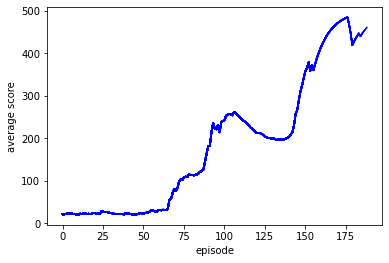

In [6]:
for episode in range(HM_EPISODES):    
    done = False
    score = 0
    steps = 0
    
    # env와 state 초기화
    state = env.reset()         

    while not done:    
        
        if agent.render:
            env.render()
        
        action = agent.get_action(state)    # action: tensor[[]]

        next_state, reward, done, info = env.step(action.item()) #next_state: np[], reward: [], done: []               
        score += reward
        reward = 0.1 if not done or score == 500 else -1        
        
        memory.push(state, action, next_state, reward, done) #state: np[], action: tensor[[]], reward: [], next_state: np[], done: []

        # (policy network에서) 최적화 한단계 수행        
        if len(memory) >= agent.train_start:
            agent.train_model()

        # 다음 상태로 이동
        state = next_state
        steps += 1

        # 마찬가지로 done이 True 라면,
        if done:
            agent.update_target_model()
            score_avg = 0.9 * score_avg + 0.1 * score if score_avg !=0 else score
            print('episode: {:3d} | score avg: {:3.2f} | steps:{:3d} | memory lengh: {:4d}'.format(
                episode, score_avg, steps, len(memory)))
            scores.append(score_avg)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('average score')
            
   
            if score_avg > 1000:
                sys.exit()       
    

    
print('Complete')
scores.clear
episodes.clear

